In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from brian2 import start_scope, prefs, run
from brian2 import NeuronGroup, PoissonGroup, Synapses, SpikeMonitor, StateMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../../lib/')

import brian2wrapper
import traces_lib

/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


## Example 1.1 - EXC network, no plasticity

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


typical spike threshold 50. mV
typical potential change per noise spike 10. mV
typical potential change per lateral spike 50. mV


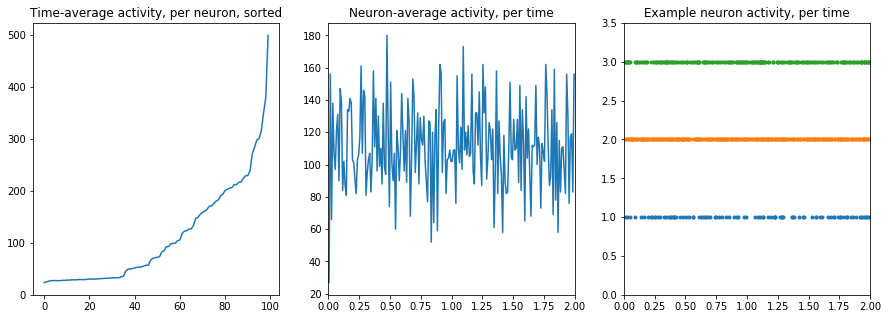

CPU times: user 2.72 s, sys: 204 ms, total: 2.93 s
Wall time: 2.6 s


In [5]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

p = {
    "N"         : 100,      # Number of neurons
    "p_conn"    : 0.01,     # Connection probability
    "nu_V"      : 10.0*mV,  # Neuronal Noise Voltage
    "nu_FREQ"   : 400*Hz,   # Neuronal Noise Frequency
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_0"   : 50.0*mV   # Neuron spike threshold
}

DV_NOISE_SPIKE = p['nu_V']                                   # Voltage increase per noise spike
DV_EXC_SPIKE = p['LIF_T_0'] / (1.0 * p['N'] * p['p_conn'])   # Voltage increase per lateral spike

print("typical spike threshold", p['LIF_T_0'])
print("typical potential change per noise spike", DV_NOISE_SPIKE)
print("typical potential change per lateral spike", DV_EXC_SPIKE)

#######################################
# Brian2 classes
#######################################

# Create neuronal populations
#G_INP = PoissonGroup(N_EXC, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_EXC   = brian2wrapper.NeuronGroupLIF(p['N'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_NOISE = PoissonGroup(p['N'], p['nu_FREQ'])

# Create synapses
S_NOISE_EXC = Synapses(G_NOISE, G_EXC, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_EXC_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_EXC_SPIKE', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_NOISE_EXC.connect(j='i')
S_EXC_EXC.connect(p=p['p_conn'])

spikemon_noise = SpikeMonitor(G_NOISE)
spikemon_exc = SpikeMonitor(G_EXC)

#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 2000*ms

run(RUN_TIME)

#######################################
# Make images
#######################################

spike_idxs = np.array(spikemon_exc.i)
spike_times = np.array(spikemon_exc.t)

spikesPerNeuron = traces_lib.spikes2lists(spike_idxs, spike_times, p['N'])
avgRatePerNeuron = np.array([len(sp) / RUN_TIME for sp in spikesPerNeuron]).astype(float)
avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(np.sort(avgRatePerNeuron))
ax[1].plot(avgNetworkRate_t, avgNetworkRate_r / p['N'])
ax[2].plot(spikesPerNeuron[0], np.ones(len(spikesPerNeuron[0])), '.')
ax[2].plot(spikesPerNeuron[1], np.ones(len(spikesPerNeuron[1])) + 1, '.')
ax[2].plot(spikesPerNeuron[2], np.ones(len(spikesPerNeuron[2])) + 2, '.')
ax[1].set_xlim([0, float(RUN_TIME)])
ax[2].set_xlim([0, float(RUN_TIME)])
ax[2].set_ylim([0, 3.5])
ax[0].set_title("Time-average activity, per neuron, sorted")
ax[1].set_title("Neuron-average activity, per time")
ax[2].set_title("Example neuron activity, per time")
plt.show()

## Example 1.2 - Balanced network, no plasticity

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


typical spike threshold 50. mV
typical potential change per noise spike 10. mV
typical potential change per lateral spike 25. mV


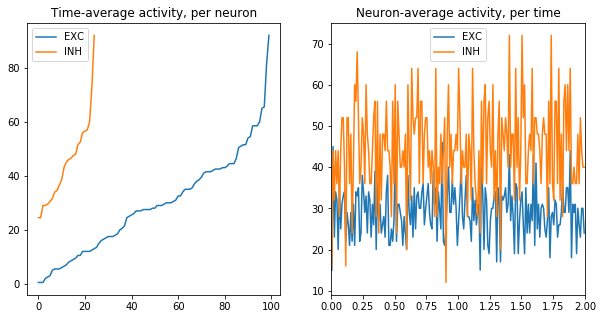

CPU times: user 3.1 s, sys: 168 ms, total: 3.27 s
Wall time: 3.03 s


In [20]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

p = {
    "N_EXC"     : 100,      # Number of neurons
    "N_INH"     : 25,       # Number of neurons
    "p_conn"    : 0.01,     # Connection probability
    "nu_V"      : 10.0*mV,  # Neuronal Noise Voltage
    "nu_FREQ"   : 400*Hz,   # Neuronal Noise Frequency
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_0"   : 50.0*mV   # Neuron spike threshold
}

DV_NOISE_SPIKE = p['nu_V']                                       # Voltage increase per noise spike
DV_EXC_SPIKE = p['LIF_T_0'] / (2.0 * p['N_EXC'] * p['p_conn'])   # Voltage increase per lateral exc spike
DV_INH_SPIKE = -4 * DV_EXC_SPIKE                                 # Voltage increase per lateral inh spike

print("typical spike threshold", p['LIF_T_0'])
print("typical potential change per noise spike", DV_NOISE_SPIKE)
print("typical potential change per lateral spike", DV_EXC_SPIKE)

#######################################
# Brian2 classes
#######################################

# Create neuronal populations
#G_INP = PoissonGroup(N_EXC, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_EXC   = brian2wrapper.NeuronGroupLIF(p['N_EXC'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_INH   = brian2wrapper.NeuronGroupLIF(p['N_INH'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_EXC_NOISE = PoissonGroup(p['N_EXC'], p['nu_FREQ'])
G_INH_NOISE = PoissonGroup(p['N_INH'], p['nu_FREQ'])

# Create synapses
S_NOISE_EXC = Synapses(G_EXC_NOISE, G_EXC, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_NOISE_INH = Synapses(G_INH_NOISE, G_INH, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_EXC_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_EXC_INH   = Synapses(G_EXC,   G_INH, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_INH_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_INH_SPIKE', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_NOISE_EXC.connect(j='i')
S_NOISE_INH.connect(j='i')
S_EXC_EXC.connect(p=p['p_conn'])
S_EXC_INH.connect(p=p['p_conn'])
S_INH_EXC.connect(p=p['p_conn'])

spikemon_exc = SpikeMonitor(G_EXC)
spikemon_inh = SpikeMonitor(G_INH)

#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 2000*ms

run(RUN_TIME)

#######################################
# Make images
#######################################

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[1].set_xlim([0, float(RUN_TIME)])
ax[0].set_title("Time-average activity, per neuron")
ax[1].set_title("Neuron-average activity, per time")

for spmon, name in zip([spikemon_exc, spikemon_inh], ["EXC", "INH"]):
    spike_idxs = np.array(spmon.i)
    spike_times = np.array(spmon.t)

    spikesPerNeuron = traces_lib.spikes2lists(spike_idxs, spike_times, p['N_'+name])
    avgRatePerNeuron = np.array([len(sp) / RUN_TIME for sp in spikesPerNeuron]).astype(float)
    avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)

    ax[0].plot(np.sort(avgRatePerNeuron), label=name)
    ax[1].plot(avgNetworkRate_t, avgNetworkRate_r / p['N_'+name], label=name)

ax[0].legend()
ax[1].legend()
plt.show()

## Example 1.3 - Balanced network, IP

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


typical spike threshold 50. mV
typical potential change per noise spike 10. mV
typical potential change per lateral spike 5. mV
typical threshold change per lateral spike 0.5 mV


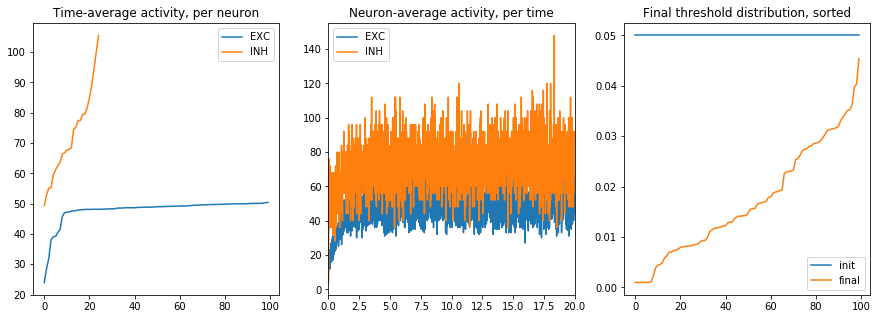

CPU times: user 35.1 s, sys: 341 ms, total: 35.4 s
Wall time: 34.9 s


In [11]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

p = {
    "N_EXC"     : 100,      # Number of neurons
    "N_INH"     : 25,       # Number of neurons
    "p_conn"    : 0.1,      # Connection probability
    "nu_V"      : 10.0*mV,  # Neuronal Noise Voltage
    "nu_FREQ"   : 400*Hz,   # Neuronal Noise Frequency
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_AVG" : 50.0*mV,  # Neuron average threshold
    "LIF_T_MIN" : 1.0*mV,   # Neuron min threshold
    "LIF_T_MAX" : 200.0*mV, # Neuron max threshold
    "LIF_T_TAU" : 2000*ms,  # Neuron base threshold
    "RATE_AVG"  : 50*Hz,    # Neuron base threshold
}

DV_NOISE_SPIKE = p['nu_V']                                         # Voltage increase per noise spike
DV_EXC_SPIKE = p['LIF_T_AVG'] / (1.0 * p['N_EXC'] * p['p_conn'])   # Voltage increase per lateral exc spike
DV_INH_SPIKE = -4 * DV_EXC_SPIKE                                   # Voltage increase per lateral inh spike
ETA_T = 1 / (p["LIF_T_AVG"] * p["RATE_AVG"] * p["LIF_T_TAU"])      # Relative threshold change per spike

print("typical spike threshold", p['LIF_T_AVG'])
print("typical potential change per noise spike", DV_NOISE_SPIKE)
print("typical potential change per lateral spike", DV_EXC_SPIKE)
print("typical threshold change per lateral spike", ETA_T*p["LIF_T_AVG"]**2)

#######################################
# Brian2 classes
#######################################

# Create neuronal populations
G_EXC   = brian2wrapper.NeuronGroupLIF_HP(p['N_EXC'], p['LIF_V_0'], p['LIF_V_TAU'], p['RATE_AVG'], p['LIF_T_MIN'], p['LIF_T_MAX'], ETA_T)
G_INH   = brian2wrapper.NeuronGroupLIF(p['N_INH'], p['LIF_V_0'], p['LIF_T_AVG'], p['LIF_V_TAU'])
G_EXC_NOISE = PoissonGroup(p['N_EXC'], p['nu_FREQ'])
G_INH_NOISE = PoissonGroup(p['N_INH'], p['nu_FREQ'])

LIF_T_AVG = p['LIF_T_AVG']
G_EXC.T = 'LIF_T_AVG'  # Initialize threshold variable

# Create synapses
S_NOISE_EXC = Synapses(G_EXC_NOISE, G_EXC, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_NOISE_INH = Synapses(G_INH_NOISE, G_INH, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_EXC_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_EXC_INH   = Synapses(G_EXC,   G_INH, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_INH_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_INH_SPIKE', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_NOISE_EXC.connect(j='i')
S_NOISE_INH.connect(j='i')
S_EXC_EXC.connect(p=p['p_conn'])
S_EXC_INH.connect(p=p['p_conn'])
S_INH_EXC.connect(p=p['p_conn'])

spikemon_exc = SpikeMonitor(G_EXC)
spikemon_inh = SpikeMonitor(G_INH)
statemon_T = StateMonitor(G_EXC, 'T', record=True, dt=10*ms)

#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 20000*ms

run(RUN_TIME)

#######################################
# Make images
#######################################

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[1].set_xlim([0, float(RUN_TIME)])
ax[0].set_title("Time-average activity, per neuron")
ax[1].set_title("Neuron-average activity, per time")
ax[2].set_title("Threshold distribution, sorted")

ax[2].plot(np.sort(statemon_T.T[:, 0]), label='init')
ax[2].plot(np.sort(statemon_T.T[:, -1]), label='final')


for spmon, name in zip([spikemon_exc, spikemon_inh], ["EXC", "INH"]):
    spike_idxs = np.array(spmon.i)
    spike_times = np.array(spmon.t)

    spikesPerNeuron = traces_lib.spikes2lists(spike_idxs, spike_times, p['N_'+name])
    avgRatePerNeuron = np.array([len(sp) / RUN_TIME for sp in spikesPerNeuron]).astype(float)
    avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)

    ax[0].plot(np.sort(avgRatePerNeuron), label=name)
    ax[1].plot(avgNetworkRate_t, avgNetworkRate_r / p['N_'+name], label=name)

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

## Example 1.4 - Balanced network, STDP

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


typical spike threshold 50. mV
typical potential change per noise spike 10. mV
typical potential change per lateral spike 5. mV


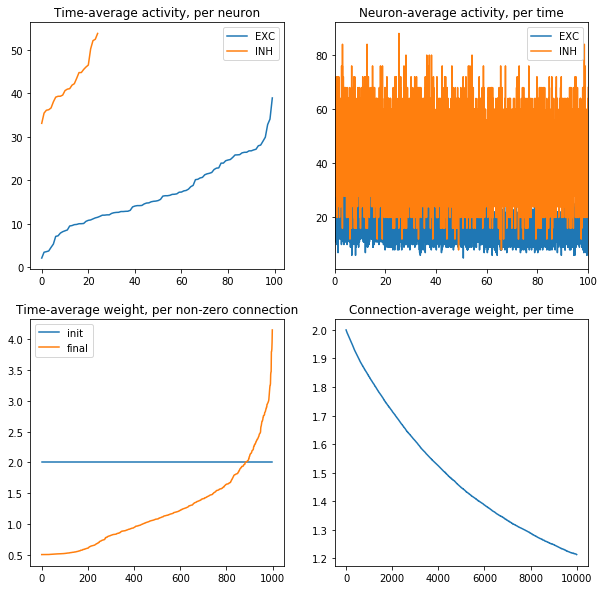

CPU times: user 2min 48s, sys: 580 ms, total: 2min 49s
Wall time: 2min 48s


In [19]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

p = {
    "N_EXC"     : 100,      # Number of neurons
    "N_INH"     : 25,       # Number of neurons
    "p_conn"    : 0.1,      # Connection probability
    "nu_V"      : 10.0*mV,  # Neuronal Noise Voltage
    "nu_FREQ"   : 400*Hz,   # Neuronal Noise Frequency
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_0"   : 50.0*mV   # Neuron spike threshold
}

DV_NOISE_SPIKE = p['nu_V']                                       # Voltage increase per noise spike
DV_EXC_SPIKE = p['LIF_T_0'] / (1.0 * p['N_EXC'] * p['p_conn'])   # Voltage increase per lateral exc spike
DV_INH_SPIKE = -4 * DV_EXC_SPIKE                                 # Voltage increase per lateral inh spike

print("typical spike threshold", p['LIF_T_0'])
print("typical potential change per noise spike", DV_NOISE_SPIKE)
print("typical potential change per lateral spike", DV_EXC_SPIKE)

#######################################
# Plasticity Model
#######################################

PLASTICITY_MODEL = {
    'TYPE'      : 'STDP',
    'DV_SPIKE'  : DV_EXC_SPIKE,
    'REL_W_MIN' : 0.5,      # Min relative weight
    'REL_W_MAX' : 5.0,      # Max relative weight
    'REL_W_0'   : 2.0,      # Avg relative weight
    'DW_FORW'   : 0.01,     # Maximal change of weight due to causal spike sequence
    'DW_BACK'   : -0.01,    # Maximal change of weight due to anti-causal spike sequence
    'TAU_PRE'   : 20*ms,    # STDP presynaptic spike trace timescale
    'TAU_POST'  : 20*ms     # STDP postsynaptic spike trace timescale    
}

#######################################
# Brian2 classes
#######################################

# Create neuronal populations
#G_INP = PoissonGroup(N_EXC, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_EXC   = brian2wrapper.NeuronGroupLIF(p['N_EXC'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_INH   = brian2wrapper.NeuronGroupLIF(p['N_INH'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_EXC_NOISE = PoissonGroup(p['N_EXC'], p['nu_FREQ'])
G_INH_NOISE = PoissonGroup(p['N_INH'], p['nu_FREQ'])

# Create synapses
S_NOISE_EXC = Synapses(G_EXC_NOISE, G_EXC, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_NOISE_INH = Synapses(G_INH_NOISE, G_INH, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_EXC_EXC   = brian2wrapper.SynapsesPlastic(G_EXC, G_EXC, PLASTICITY_MODEL)
S_EXC_INH   = Synapses(G_EXC,   G_INH, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_INH_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_INH_SPIKE', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_NOISE_EXC.connect(j='i')
S_NOISE_INH.connect(j='i')
S_EXC_EXC.connect(p=p['p_conn'])
S_EXC_INH.connect(p=p['p_conn'])
S_INH_EXC.connect(p=p['p_conn'])

# Initialize STDP variable
S_EXC_EXC.w = 'REL_W_0'

spikemon_exc = SpikeMonitor(G_EXC)
spikemon_inh = SpikeMonitor(G_INH)

statemon_s_exc_exc = StateMonitor(S_EXC_EXC, 'w', record=True, dt=10*ms)

#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 100000*ms

run(RUN_TIME)

#######################################
# Make images
#######################################

fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10))
ax[0][1].set_xlim([0, float(RUN_TIME)])
ax[0][0].set_title("Time-average activity, per neuron")
ax[0][1].set_title("Neuron-average activity, per time")
ax[1][0].set_title("Time-average weight, per non-zero connection")
ax[1][1].set_title("Connection-average weight, per time")

for spmon, name in zip([spikemon_exc, spikemon_inh], ["EXC", "INH"]):
    spike_idxs = np.array(spmon.i)
    spike_times = np.array(spmon.t)

    spikesPerNeuron = traces_lib.spikes2lists(spike_idxs, spike_times, p['N_'+name])
    avgRatePerNeuron = np.array([len(sp) / RUN_TIME for sp in spikesPerNeuron]).astype(float)
    avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)

    ax[0][0].plot(np.sort(avgRatePerNeuron), label=name)
    ax[0][1].plot(avgNetworkRate_t, avgNetworkRate_r / p['N_'+name], label=name)

ax[1][0].plot(np.sort(statemon_s_exc_exc.w[:, 0]), label='init')
ax[1][0].plot(np.sort(statemon_s_exc_exc.w[:, -1]), label='final')
ax[1][1].plot(np.mean(statemon_s_exc_exc.w, axis=0))

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
plt.show()

## Example 1.5 - Balanced Network, STDP+HP

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


typical spike threshold 50. mV
typical potential change per noise spike 10. mV
typical potential change per lateral spike 5. mV
typical threshold change per lateral spike 50. uV


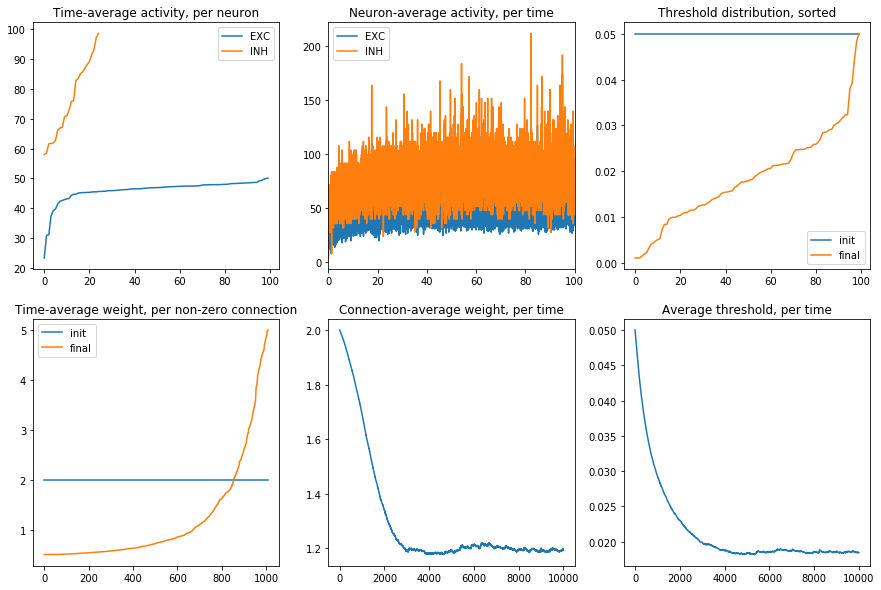

CPU times: user 3min 35s, sys: 932 ms, total: 3min 36s
Wall time: 3min 35s


In [17]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

p = {
    "N_EXC"     : 100,      # Number of neurons
    "N_INH"     : 25,       # Number of neurons
    "p_conn"    : 0.1,      # Connection probability
    "nu_V"      : 10.0*mV,  # Neuronal Noise Voltage
    "nu_FREQ"   : 400*Hz,   # Neuronal Noise Frequency
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_AVG" : 50.0*mV,  # Neuron average threshold
    "LIF_T_MIN" : 1.0*mV,   # Neuron min threshold
    "LIF_T_MAX" : 200.0*mV, # Neuron max threshold
    "LIF_T_TAU" : 20000*ms, # Neuron base threshold
    "RATE_AVG"  : 50*Hz,    # Neuron base threshold
}

DV_NOISE_SPIKE = p['nu_V']                                         # Voltage increase per noise spike
DV_EXC_SPIKE = p['LIF_T_AVG'] / (1.0 * p['N_EXC'] * p['p_conn'])   # Voltage increase per lateral exc spike
DV_INH_SPIKE = -4 * DV_EXC_SPIKE                                   # Voltage increase per lateral inh spike
ETA_T = 1 / (p["LIF_T_AVG"] * p["RATE_AVG"] * p["LIF_T_TAU"])      # Relative threshold change per spike

print("typical spike threshold", p['LIF_T_AVG'])
print("typical potential change per noise spike", DV_NOISE_SPIKE)
print("typical potential change per lateral spike", DV_EXC_SPIKE)
print("typical threshold change per lateral spike", ETA_T*p["LIF_T_AVG"]**2)


#######################################
# Plasticity Model
#######################################

PLASTICITY_MODEL = {
    'TYPE'      : 'STDP',
    'DV_SPIKE'  : DV_EXC_SPIKE,
    'REL_W_MIN' : 0.5,      # Min relative weight
    'REL_W_MAX' : 5.0,      # Max relative weight
    'REL_W_0'   : 2.0,      # Avg relative weight
    'DW_FORW'   : 0.01,     # Maximal change of weight due to causal spike sequence
    'DW_BACK'   : -0.01,    # Maximal change of weight due to anti-causal spike sequence
    'TAU_PRE'   : 20*ms,    # STDP presynaptic spike trace timescale
    'TAU_POST'  : 20*ms     # STDP postsynaptic spike trace timescale    
}

#######################################
# Brian2 classes
#######################################

# Create neuronal populations
G_EXC   = brian2wrapper.NeuronGroupLIF_HP(p['N_EXC'], p['LIF_V_0'], p['LIF_V_TAU'], p['RATE_AVG'], p['LIF_T_MIN'], p['LIF_T_MAX'], ETA_T)
G_INH   = brian2wrapper.NeuronGroupLIF(p['N_INH'], p['LIF_V_0'], p['LIF_T_AVG'], p['LIF_V_TAU'])
G_EXC_NOISE = PoissonGroup(p['N_EXC'], p['nu_FREQ'])
G_INH_NOISE = PoissonGroup(p['N_INH'], p['nu_FREQ'])

LIF_T_AVG = p['LIF_T_AVG']
G_EXC.T = 'LIF_T_AVG'  # Initialize threshold variable

# Create synapses
S_NOISE_EXC = Synapses(G_EXC_NOISE, G_EXC, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_NOISE_INH = Synapses(G_INH_NOISE, G_INH, on_pre='v_post += DV_NOISE_SPIKE', method='exact')
S_EXC_EXC   = brian2wrapper.SynapsesPlastic(G_EXC, G_EXC, PLASTICITY_MODEL)
S_EXC_INH   = Synapses(G_EXC,   G_INH, on_pre='v_post += DV_EXC_SPIKE', method='exact')
S_INH_EXC   = Synapses(G_EXC,   G_EXC, on_pre='v_post += DV_INH_SPIKE', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_NOISE_EXC.connect(j='i')
S_NOISE_INH.connect(j='i')
S_EXC_EXC.connect(p=p['p_conn'])
S_EXC_INH.connect(p=p['p_conn'])
S_INH_EXC.connect(p=p['p_conn'])

# Initialize STDP variable
S_EXC_EXC.w = 'REL_W_0'

spikemon_exc = SpikeMonitor(G_EXC)
spikemon_inh = SpikeMonitor(G_INH)

statemon_s_exc_exc = StateMonitor(S_EXC_EXC, 'w', record=True, dt=10*ms)
statemon_T = StateMonitor(G_EXC, 'T', record=True, dt=10*ms)

#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 100000*ms

run(RUN_TIME)

#######################################
# Make images
#######################################

fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(15, 10))
ax[0][1].set_xlim([0, float(RUN_TIME)])
ax[0][0].set_title("Time-average activity, per neuron")
ax[0][1].set_title("Neuron-average activity, per time")
ax[0][2].set_title("Threshold distribution, sorted")
ax[1][0].set_title("Time-average weight, per non-zero connection")
ax[1][1].set_title("Connection-average weight, per time")
ax[1][2].set_title("Average threshold, per time")

ax[1][2].plot(np.mean(statemon_T.T, axis=0))
ax[0][2].plot(np.sort(statemon_T.T[:, 0]), label='init')
ax[0][2].plot(np.sort(statemon_T.T[:, -1]), label='final')

for spmon, name in zip([spikemon_exc, spikemon_inh], ["EXC", "INH"]):
    spike_idxs = np.array(spmon.i)
    spike_times = np.array(spmon.t)

    spikesPerNeuron = traces_lib.spikes2lists(spike_idxs, spike_times, p['N_'+name])
    avgRatePerNeuron = np.array([len(sp) / RUN_TIME for sp in spikesPerNeuron]).astype(float)
    avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)

    ax[0][0].plot(np.sort(avgRatePerNeuron), label=name)
    ax[0][1].plot(avgNetworkRate_t, avgNetworkRate_r / p['N_'+name], label=name)

ax[1][0].plot(np.sort(statemon_s_exc_exc.w[:, 0]), label='init')
ax[1][0].plot(np.sort(statemon_s_exc_exc.w[:, -1]), label='final')
ax[1][1].plot(np.mean(statemon_s_exc_exc.w, axis=0))

ax[0][0].legend()
ax[0][1].legend()
ax[0][2].legend()
ax[1][0].legend()
plt.show()